In [1]:
%matplotlib inline


# Comparison of Manifold Learning methods


An illustration of dimensionality reduction with various manifold learning methods.


Note that the purpose of the MDS is to find a low-dimensional
representation of the data (here 2D) in which the distances respect well
the distances in the original high-dimensional space, unlike other
manifold-learning algorithms, it does not seeks an isotropic
representation of the data in the low-dimensional space.



In [261]:
import sys
sys.path.append('/home/utilisateur/ElpiGraph.Tensorflow2_eager/')
sys.path.append('/home/utilisateur/ElpiGraph.Tensorflow2_eager/elpigraph/core_algorithm/')

from elpigraph import *
from PartitionData import PartitionData

import matplotlib.pyplot as plt
from time import time
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

import numpy as np
from sklearn import manifold, datasets
from sklearn.neighbors import NearestNeighbors
from umap import UMAP
import networkx as nx

### Testing ElPiGraph viz

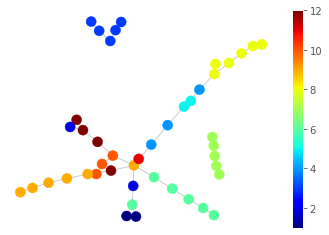

In [264]:
# X = np.loadtxt('examples/ext10_10_2.txt')
# nnodes = 12*4

# #heuristic to decide optional trimming radius
# nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(X)
# distances, indices = nbrs.kneighbors(X)

# NodeP, EM, Edges = computeElasticPrincipalTree.computeElasticPrincipalTree(X,nnodes,TrimmingRadius=np.inf)
# NodeP, Edges = NodeP.squeeze(), Edges.squeeze()

# #compute datapoint to associate with each node
# partition, dists = PartitionData(X,NodeP,MaxBlockSize=10**6, SquaredX = (X**2).sum(axis=1).reshape((X.shape[0], 1)))

# #remove nodes with no associated datapoint
# empty_nodes = list(set(range(nnodes))-set(np.unique(partition)))
# Edges2=Edges
# ind_to_del = []
# for i in range(Edges.shape[1]):
#     if (Edges2[0,i] in empty_nodes) or (Edges2[1,i] in empty_nodes):
#         ind_to_del.append(i)
# Edges2 = np.delete(Edges2,ind_to_del,axis=1)

# #associate color(s) to nodes
# pie_col_nodes = []
# main_col_nodes = []
# for i0,i in enumerate(np.unique(Edges2)):
#     pie_col_nodes.append(color[np.where(partition.squeeze()==i)[0]])
#     main_col_nodes.append(np.argmax(np.bincount(pie_col_nodes[i0])))

### Draw graph
g=nx.Graph()
g.add_edges_from(Edges2.T)
pos = nx.spring_layout(g,scale=2)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(g, pos,
                            nodelist=list(np.unique(Edges2)),
                            node_color=main_col_nodes, 
                            node_size=100,
                            cmap=plt.cm.jet)


plt.colorbar(nc)
plt.axis('off')
plt.show()

standard: 0.5 sec
ltsa: 0.88 sec
hessian: 1.1 sec
modified: 0.96 sec
Isomap: 2.3 sec
MDS: 11 sec
SpectralEmbedding: 0.47 sec
t-SNE: 8 sec
UMAP: 6.1 sec
Iteration:  1
Performing PCA on the data
Computing EPG with  48  nodes on  1584  points and  10  dimensions
NODE:
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 
E= 0.01711406726096649 , MSE= 0.006721355362218206 , EP= 0.009644865019535312 , RP= 0.0007478468792129732
Done
ElPiGraph: 1.8e+02 sec


/home/utilisateur/.conda/envs/Tensorflow/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


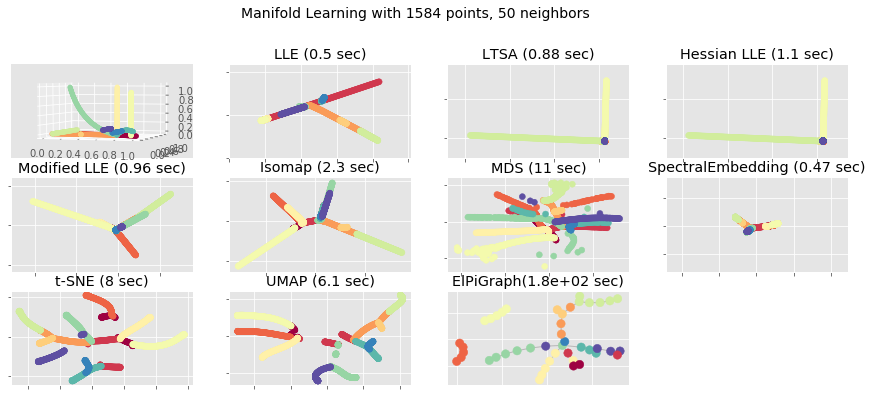

In [263]:
# Next line to silence pyflakes. This import is needed.
Axes3D


X = np.loadtxt('examples/ext10_10_2.txt');
color = np.loadtxt('examples/ext10_10_2.irx').astype('int')
n_points = X.shape[0]
#color = np.full((n_points,),1)
#color[0:49] = 2
#color[50:99] = -1
n_points = X.shape[0]
n_neighbors = 50
n_components = 2

fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (n_points, n_neighbors), fontsize=14)


ax = fig.add_subplot(441, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)

methods = ['standard', 'ltsa', 'hessian', 'modified']
labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

for i, method in enumerate(methods):
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(4,4,2 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

t0 = time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(446)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(447)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(448)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(4,4,9)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
um = UMAP(n_neighbors=n_neighbors,
          n_components=n_components)
Y = um.fit_transform(X)
t1 = time()
print("UMAP: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(4,4,10)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("UMAP (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


### ElPiGraph ###

nnodes = 12*4

#heuristic to decide optional trimming radius
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

t0 = time()
NodeP, EM, Edges = computeElasticPrincipalTree.computeElasticPrincipalTree(X,nnodes,TrimmingRadius=np.inf)
NodeP, Edges = NodeP.squeeze(), Edges.squeeze()
t1 = time()
print("ElPiGraph: %.2g sec" % (t1 - t0))

#compute datapoint to associate with each node
partition, dists = PartitionData(X,NodeP,MaxBlockSize=10**6, SquaredX = (X**2).sum(axis=1).reshape((X.shape[0], 1)))

#remove nodes with no associated datapoint
empty_nodes = list(set(range(nnodes))-set(np.unique(partition)))
Edges2=Edges
ind_to_del = []
for i in range(Edges.shape[1]):
    if (Edges2[0,i] in empty_nodes) or (Edges2[1,i] in empty_nodes):
        ind_to_del.append(i)
Edges2 = np.delete(Edges2,ind_to_del,axis=1)

#associate color(s) to nodes
pie_col_nodes = []
main_col_nodes = []
for i0,i in enumerate(np.unique(Edges2)):
    pie_col_nodes.append(color[np.where(partition.squeeze()==i)[0]])
    main_col_nodes.append(np.argmax(np.bincount(pie_col_nodes[i0])))

### Draw graph
ax = fig.add_subplot(4,4,11)

g=nx.Graph()
g.add_edges_from(Edges2.T)
pos = nx.spring_layout(g,scale=2)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(g, pos,
                            nodelist=list(np.unique(Edges2)),
                            node_color=main_col_nodes, 
                            node_size=70,
                            cmap=plt.cm.Spectral)



plt.title("ElPiGraph(%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


plt.show()